# Zadanie domowe 3
## Mateusz Krzyziński

Przedmiotem zadania domowego 3 jest wytrenowanie dowolnych trzech klasyfikatorów i sprawdzenie ich skuteczności. Modele klasyfikacyjne mają przewidywać na podstawie danych pogodowych z Australii, czy następnego dnia będzie padać deszcz, czy nie. 


### Wczytanie pakietów, danych i podział na zbiory
Mamy do czynienia ze zbiorem dotyczącym obserwacji pogodowych z australijskich stacji meteorologicznych. Jest on już przygotowany do pracy, ale dla porządku warto sprawdzić, jak wygląda. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
np.random.seed = 42

In [2]:
df = pd.read_csv('australia.csv')

In [3]:
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,19.3,33.4,0.0,6.0,11.0,35.0,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0,0
56416,21.2,32.6,0.0,7.6,8.6,37.0,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0,0
56417,20.7,32.8,0.0,5.6,11.0,33.0,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0,0
56418,19.5,31.8,0.0,6.2,10.6,26.0,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0,0


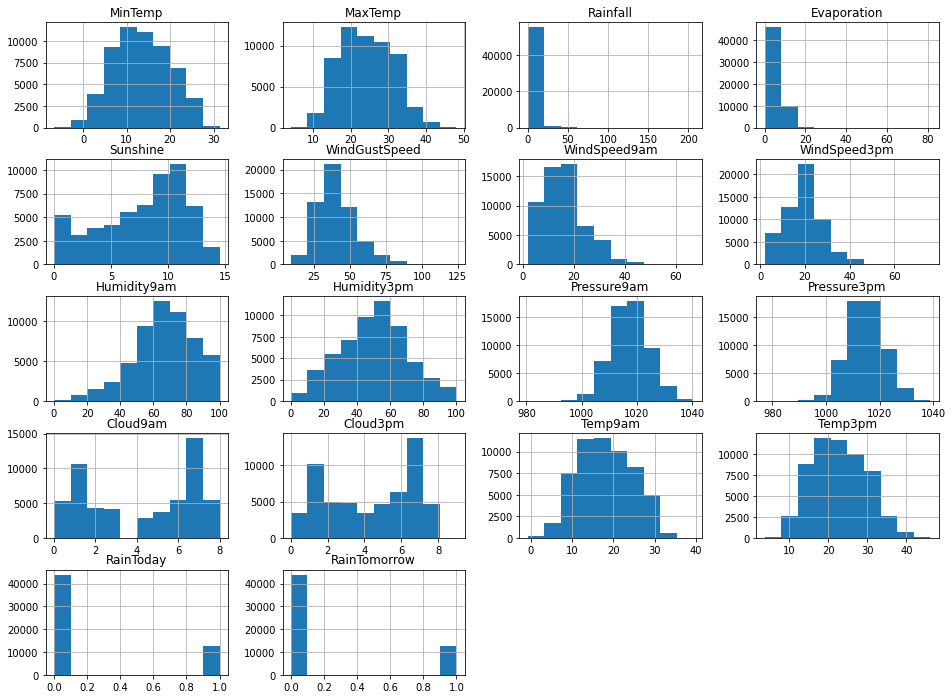

In [4]:
df.hist(figsize=(16,12))
plt.show()

Powyżej widzimy, że większość zmiennych ma rozkłady przypominające normalne, ale w różnych zakresach liczbowych - warto pomyśleć o skalowaniu. 

In [5]:
# Podział na target i zmienne wyjaśniające
y = df['RainTomorrow']
X = df.drop(['RainTomorrow'],axis=1)

In [6]:
y.value_counts()

0    43993
1    12427
Name: RainTomorrow, dtype: int64

Sprawdzenie rozkładu targetu pokazuje, że nie jest on tak zaburzony jak można by się spodziewać (przynajmniej ja sądziłem, że dni z deszczem będzie jeszcze mniej). Pomimo to warto zadbać o proporcjonalny podział obserwacji do zbioru treningowego i testowego. W szczególności, argumentem przemawiającym za tym jest również specyfika zadania - ze względu na (jeszcze ostatkami sił 😥) stabilny klimat w przyszłości nowe dane powinny mieć podobny rozkład. 

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Nauka modeli i ocena jakości 
Stworzymy trzy różne modele klasyfikacyjne. Każdy z nich będziemy sprawdzali, wykorzystując trzy miary jakości:
- accuracy,
- F1 score (średnia harmoniczna z precission i recall)
- ROC AUC (łączy recall i False Positive Rate (1 - specificity)).
Dzięki zastosowaniu różnych miar będziemy mieli większą pewność odnośnie jakości wytrenowanych klasyfikatorów, gdyż intuicyjne accuracy może go nie odzwierciedlać. Dają nam również dodatkowe informacje o popełnianych błędach - np. precyzji modelu i uciekających predykcjach (recall). 

Wyliczymy średnie wartości poszczególnych miar w kroswalidacji na zbiorze treningowym oraz wartości dla zbioru testowego. 

In [8]:
# Funkcja pomocnicza agregująca miary z kroswalidacji i tworząca DataFrame do późniejszej wizualizacji
def get_results(cv_results, model_name):
    print("--- Performance measures values for", model_name, "---")
    for measure in ["test_accuracy", "test_f1", "test_roc_auc"]:
        print(measure.split("_", 1)[1], " | ",  f"mean: {np.mean(cv_results[measure]):.4f}, min: {min(cv_results[measure]):.4f}, max: {max(lr_cv_results[measure]):.4f}")
    return pd.DataFrame({"model": model_name, "accuracy_score": cv_results["test_accuracy"], "f1_score": cv_results["test_f1"], "roc_auc_score": cv_results["test_roc_auc"]})

In [9]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
kfolds = 10
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

#### Pierwszy model - regresja logistyczna
Wybrane hiperparametry: 
- `penalty = 'lasticnet'` - regresja liniowo łacząca kary Ridge ($L_2$) i Lasso($L_1$) ograniczające wartości wag, 
- `solver = 'saga'` - algorytm użyty w optymalizacji wag, konieczny do zastosowania ElasticNet,
- `l1_ratio = 0.8` - współczynnik istotności kary $L_1$ w branej pod uwagę kombinacji liniowej.

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.8)

lr_model = Pipeline(steps=[('standardscaler', StandardScaler()),   #stosujemy standaryzację 
                ('lr', lr)])  

lr_cv_results = cross_validate(lr_model, 
                 X_train, y_train, 
                 cv=split,
                 scoring=["accuracy", "f1", "roc_auc"],
                          n_jobs=-1)

lr_res_df = get_results(lr_cv_results, "LogisticRegression")

--- Performance measures values for LogisticRegression ---
accuracy  |  mean: 0.8532, min: 0.8463, max: 0.8664
f1  |  mean: 0.6155, min: 0.5884, max: 0.6428
roc_auc  |  mean: 0.8843, min: 0.8776, max: 0.8954


#### Drugi model - las losowy
Wybrane hiperparametry: 
- `min_samples_leaf = 3` - minimala liczba obserwacji, które muszą znaleźć się w liściu drzewa - większe wartości zapobiegają dużej wariancji,
- `min_samples_split = 7` - minimalna liczba obserwacji w węźle konieczna do podzielenia go - podobnie jak wyżej,
- `max_depth = 20` - maksymalna głębokość pojedynczego drzewa - zmniejszenie powoduje zmniejszenie wariancji,
- `n_estimators = 200` - liczba drzew w modelu,
- `max_features = 'sqrt'` - maksymalna liczba cech rozważanych przy dzieleniu węzłów w drzewach. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf=3, min_samples_split=7, max_depth=20, 
                             n_estimators=200, max_features='sqrt', n_jobs = -1)

rf_model = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rf', rf)])
    
rf_cv_results = cross_validate(rf_model, 
                 X_train, y_train, 
                 cv=split,
                 scoring=["accuracy", "f1", "roc_auc"],
                          n_jobs=-1)

rf_res_df = get_results(rf_cv_results, "RandomForest")

--- Performance measures values for RandomForest ---
accuracy  |  mean: 0.8604, min: 0.8542, max: 0.8664
f1  |  mean: 0.6256, min: 0.6002, max: 0.6428
roc_auc  |  mean: 0.8941, min: 0.8822, max: 0.8954


#### Trzeci model - klasyfikator metodą k najbliższych sąsiadów
Wybrane hiperparametry: 
- `n_neighbors = 8` - liczba sąsiadów branych pod uwagę w tworzeniu predykcji, 
- `weights = 'distance'` - waga poszczególnych sąsiadów w predykcji związana jest z odległością od obserwacji - czym mniejsza, tym większa waga, 
- `p = 1.5` - metryka odległości (w tym przypadku uogólniona odległość Minkowskiego $L_{1.5}$).

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8, weights='distance', p=1.5, n_jobs=-1)

knn_model = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('knn', knn)])

knn_cv_results = cross_validate(knn_model, 
                 X_train, y_train, 
                 cv=split,
                 scoring=["accuracy", "f1", "roc_auc"],
                          n_jobs=-1)

knn_res_df = get_results(knn_cv_results, "KNN")

--- Performance measures values for KNN ---
accuracy  |  mean: 0.8473, min: 0.8374, max: 0.8664
f1  |  mean: 0.6003, min: 0.5687, max: 0.6428
roc_auc  |  mean: 0.8585, min: 0.8440, max: 0.8954


#### Miary z kroswalidacji

In [19]:
cv_results_df = pd.concat([lr_res_df, rf_res_df, knn_res_df], axis=0)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

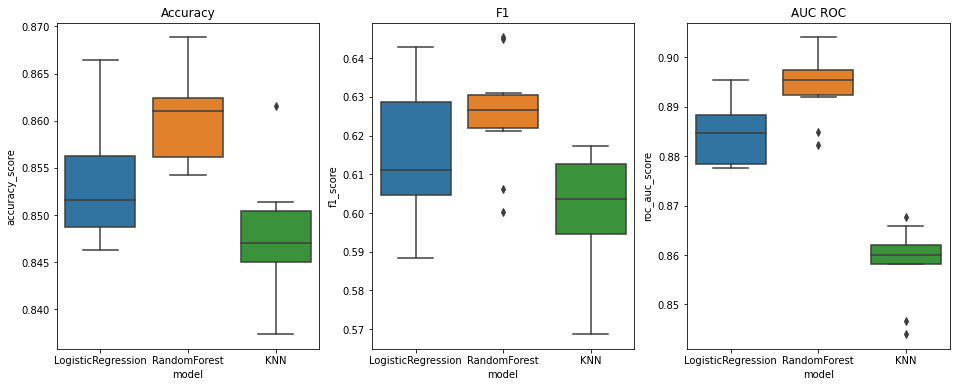

In [33]:
plt.subplots(figsize=(16,6))

plt.subplot(1, 3, 1)
sns.boxplot(data = cv_results_df, x = "model", y = "accuracy_score")
plt.title('Accuracy')

plt.subplot(1, 3, 2)
sns.boxplot(data = cv_results_df, x = "model", y = "f1_score")
plt.title('F1')

plt.subplot(1, 3, 3)
sns.boxplot(data = cv_results_df, x = "model", y = "roc_auc_score")
plt.title('AUC ROC')

plt.show()

#### Sprawdzenie modeli na zbiorze testowym

In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

test_results = []
for model, model_name in [(lr_model, "LogisticRegression"), (rf_model, "RandomForest"), (knn_model, "KNN")]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures_results = {"model": model_name}
    for measure in [accuracy_score, f1_score, roc_auc_score]:
        measures_results[measure.__name__] = measure(y_test, y_pred)
    test_results.append(measures_results)
    
test_results_df = pd.DataFrame(test_results)

In [42]:
test_results_df = pd.melt(test_results_df, id_vars="model", var_name="measure", value_name="value")

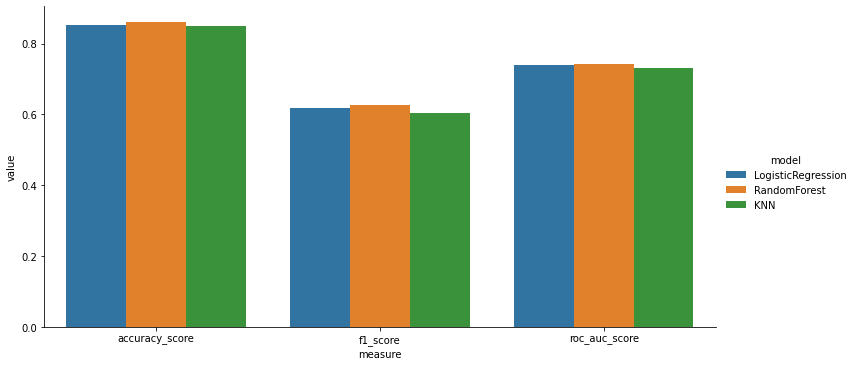

In [68]:
sns.catplot(x='measure', y='value', hue='model', data=test_results_df, kind='bar', aspect=2)
plt.show()

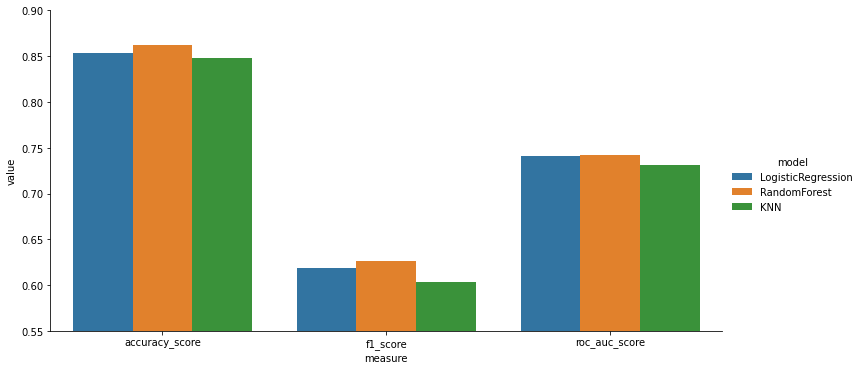

In [64]:
# lepiej widać różnice, gdy obetniemy oś y
sns.catplot(x='measure', y='value', hue='model', data=test_results_df, kind='bar', aspect=2)
plt.ylim(0.55, 0.9)
plt.show()

#### Wnioski
- Najlepszym z wytrenowanych modeli okazuje się być las losowy, dla którego każda z rozważanych miar jest lepsza od ich wartości dla innych modeli.  
- Nie można się jednak przywiązywać do wyników modeli, gdyż zostały one wytrenowane dla konkretnych wartości hiperparametrów, które nie zostały zoptymalizowane. 
- W zależności od tego, na czym nam zależy moglibyśmy optymalizować model pod kątem różnych miar:
    - możemy przykładowo chcieć przewidywać każdy dzień deszczowy (optymalizować recall) albo nie chcieć tworzyć fałszywych predykcji i przewidywać deszczu, gdy go nie będzie (optymalizować precission) lub w połączeniu rozważać F1 score, co wydaje się najbardziej sensowne.
- Wybór miary klasyfikatora nie jest łatwy. Na pewno warto rozpatrzeć więcej miar niż accuracy (zauważmy bowiem, że np. w przypadku niezbalansowanych klas może on dawać wysokie wyniki, przewidując zawsze bardziej liczną klasę). 

